In [ ]:
import warnings
warnings.filterwarnings('ignore')

_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from tensorflow.contrib.layers import fully_connected as FC_Net
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from sksurv.metrics import concordance_index_ipcw, concordance_index_censored, brier_score

from helpers.data_loader import *
from helpers.utils_others import *

from models.model import *
from helpers.utils_others import *

### IMPORT DATASET

In [2]:
OUT_ITERATION               = 5
data_mode                   = 'STRATCANS_v1_new2'
seed                        = 1234

(data_xs, data_xt, data_time, data_y, data_tte), (feat_static, feat_timevarying), (xt_bin_list, xt_con_list) = import_dataset_STRATCANS_v1()


# removes first and secondary pearson score
data_xs           = data_xs[:, [0,1,2,3,4,5,6]]
feat_static       = feat_static[[0,1,2,3,4,5,6]]

data_xt           = data_xt[:, :, [0,1,2,3,6,7,8,9,10]]
feat_timevarying  = feat_timevarying[[0,1,2,3,6,7,8,9,10]]
xt_con_list       = [0, 1, 2, 3, 4, 5, 6, 7]

x_dim_static      = len(feat_static)
x_dim_timevarying = len(feat_timevarying) # this includes delta

max_length                  = np.shape(data_time)[1]
num_Event                   = len(np.unique(data_y)) - 1  #number of next outcome events

data_y_new   = np.zeros([np.shape(data_y)[0], max_length, num_Event])
data_tte_new = np.zeros([np.shape(data_y)[0], max_length, num_Event])

seq_length = np.sum(np.sum(data_xt, axis=2) != 0, axis=1)

for i in range(np.shape(data_y)[0]):
    data_y_new[i, :seq_length[i], :]   = data_y[i]
    data_tte_new[i, :seq_length[i], :] = data_tte[i]

In [3]:
#====================================================
##### HYPER-PARAMETERS
mb_size                     = 64

iteration                   = 50000

keep_prob                   = 0.6
lr_train                    = 5e-4

h_dim_RNN                   = 100
h_dim_FC                    = 100

num_layers_RNN              = 2
num_layers_FC               = 3


RNN_type                    = 'GRU' #GRU, LSTM
BiRNN                       = None #if not 'None''BiRNN'

FC_active_fn                = tf.nn.relu

initial_W                   = tf.contrib.layers.xavier_initializer()

alpha                       = 1.0  #for stepahead-prediction loss
p_weibull                   = 1.0 #1.1  #1.0 # 0.5 or 1.0 performed good...


reg_scale                   = 0.


##### MAKE DICTIONARIES
# INPUT DIMENSIONS
input_dims                  = { 'x_dim_static'      : x_dim_static,
                                'x_dim_timevarying' : x_dim_timevarying, #this includes delta
                                'num_Event'         : num_Event,         #next-event types
                                'xt_con_list'       : xt_con_list,
                                'xt_bin_list'       : xt_bin_list,
                                'max_length'        : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'p_weibull'         : p_weibull,
                                'h_dim_RNN'         : h_dim_RNN,
                                'h_dim_FC'          : h_dim_FC,
                                'num_layers_RNN'    : num_layers_RNN,
                                'num_layers_FC'     : num_layers_FC,
                                'RNN_type'          : RNN_type,
                                'BiRNN'             : BiRNN,
                                'FC_active_fn'      : FC_active_fn,
                                'RNN_active_fn'     : tf.nn.tanh,
                                'initial_W'         : initial_W,
                                'reg_scale'         : reg_scale}

In [4]:
seed = 1234
out_itr = 2

In [5]:
PRED_TIMES = [0, 365, 365*2, 365*3]
EVAL_TIMES = [365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9, 365*10]

FINAL_RESULT1 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])
FINAL_RESULT2 = np.zeros([OUT_ITERATION, len(PRED_TIMES), len(EVAL_TIMES)])

save_path = './{}/p{}/itr{}'.format(data_mode, p_weibull, out_itr)

if not os.path.exists(save_path + '/models/'):
    os.makedirs(save_path + '/models/')

if not os.path.exists(save_path + '/results/'):
    os.makedirs(save_path + '/results/')

(tr_data_s,te_data_s, tr_data_t,te_data_t, tr_time,te_time, tr_tte,te_tte, tr_label,te_label, tr_tte_new,te_tte_new, tr_label_new,te_label_new) = train_test_split(
    data_xs, data_xt, data_time, data_tte, data_y, data_tte_new, data_y_new, test_size=0.2, random_state=seed+out_itr
) 

(tr_data_s,va_data_s, tr_data_t,va_data_t, tr_time,va_time, tr_tte,va_tte, tr_label,va_label, tr_tte_new,va_tte_new, tr_label_new,va_label_new) = train_test_split(
    tr_data_s, tr_data_t, tr_time, tr_tte, tr_label, tr_tte_new, tr_label_new, test_size=0.2, random_state=seed+out_itr
)

tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = Model_DeepHit_Weibull(sess, "Version1", input_dims, network_settings)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

CHECK_STEP = 100

min_loss = 1e8
max_flag = 50

avg_loss_tte   = 0   
avg_loss_mle   = 0
stopflag = 0


xs_mb, xt_mb, t_mb, tte_mb, m_mb = f_get_minibatch(
    mb_size, tr_data_s, tr_data_t, tr_time, tr_tte_new, tr_label_new
)

saver.restore(sess, save_path + '/models/model_tte')
enc_vars   = sess.run(model.enc_vars)
pred_vars  = sess.run(model.pred_vars)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./STRATCANS_v1_new2/p1.0/itr2/models/model_tte


In [1061]:
h_dim_selector       = 100
num_layers_selector  = 3

# h_dim_selector       = 100
# num_layers_selector  = 2

K     = 10
z_dim = h_dim_RNN * num_layers_RNN

network_settings['h_dim_s']         = h_dim_selector
network_settings['num_layers_s']    = num_layers_selector

input_dims['max_cluster'] = K



In [1063]:
tf.reset_default_graph()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
# config      = tf.ConfigProto(gpu_options=gpu_options)
config      = tf.ConfigProto()
sess        = tf.Session(config=config)
model       = ACTPC_DeepHit_Weibull(sess, "Version1_ACTPC", input_dims, network_settings)

# saver = tf.train.Saver()
# sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer(), feed_dict={model.E:np.zeros([K, z_dim]).astype(float)})

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [563]:
for n in range(len(enc_vars)):
    _ = sess.run(tf.assign(model.blackbox_enc_vars[n], enc_vars[n]))
    _ = sess.run(tf.assign(model.vars_encoder[n], enc_vars[n]))

for n in range(len(pred_vars)):
    _ = sess.run(tf.assign(model.blackbox_pred_vars[n], pred_vars[n]))
    _ = sess.run(tf.assign(model.vars_predictor[n], pred_vars[n]))

In [564]:
lr_rate1 = 1e-4
lr_rate2 = 1e-4

keep_prob = 0.7

In [565]:
print('=============================================')
print('===== INITIALIZING EMBEDDING & SELECTOR =====')
# K-means over the latent encodings
e, s_init, tmp_z = initialize_embedding(model, tr_data_s, tr_data_t, K)
e = np.arctanh(e)
sess.run(model.EE.initializer, feed_dict={model.E:e}) #model.EE = tf.nn.tanh(model.E)


===== INITIALIZING EMBEDDING & SELECTOR =====


In [386]:
print('=============================================')
print('===== INITIALIZING EMBEDDING & SELECTOR =====')
# K-means over the latent encodings
e, s_init, tmp_z = initialize_embedding(model, tr_data_s, tr_data_t, K)
e = np.arctanh(e)
sess.run(model.EE.initializer, feed_dict={model.E:e}) #model.EE = tf.nn.tanh(model.E)

# update selector wrt initial classes
ITERATION  = 1000
check_step = 500

avg_loss_s = 0
for itr in range(ITERATION):
    z_mb, s_mb = f_get_minibatch(mb_size, tmp_z, s_init)
    _, tmp_loss_s = model.train_selector(z_mb, s_mb, lr_rate1, k_prob=keep_prob)

    avg_loss_s += tmp_loss_s/check_step
    if (itr+1)%check_step == 0:
        print("ITR:{:04d} | Loss_s:{:.4f}".format(itr+1, avg_loss_s) )
        avg_loss_s = 0

tmp_ybars = model.get_lambdas_yy(np.tanh(e))
new_e     = np.copy(e)
print('=============================================')

===== INITIALIZING EMBEDDING & SELECTOR =====
ITR:0500 | Loss_s:1.4916
ITR:1000 | Loss_s:0.5954


In [387]:
np.sum(s_init==9)

355

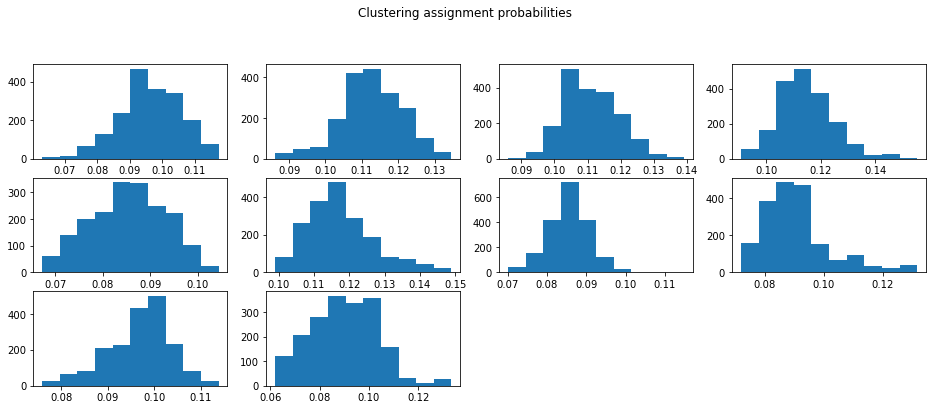

In [430]:
import matplotlib.pyplot as plt

_, tmp_pi, tmp_m = model.get_zbars_and_pis_m2(te_data_s, te_data_t)

tmp_pi = tmp_pi.reshape([-1, K])[tmp_m.reshape([-1]) == 1]

ncol = nrow = int(np.ceil(np.sqrt(K)))
plt.figure(figsize=[4*ncol, 2*nrow])
for k in range(K):
    plt.subplot(ncol, nrow, k+1)
    plt.hist(tmp_pi[:, k])
plt.suptitle("Clustering assignment probabilities")
plt.show()
# plt.savefig(save_path + 'results/figure_clustering_assignments.png')
plt.close()


In [431]:
alpha  = 0.1
beta   = 1.0
gamma  = 1.0

In [432]:
mb_size   = 64

In [433]:
def f_get_minibatch(mb_size, x1, x2, x3=None, x4=None, x5=None):
    idx = range(np.shape(x1)[0])
    idx = random.sample(idx, mb_size)

    x1_mb    = x1[idx].astype(float)
    x2_mb    = x2[idx].astype(float)
    
    if x3 is not None:
        x3_mb     = x3[idx].astype(float)
    
    if x4 is not None:
        x4_mb   = x4[idx].astype(float)
    
    if x5 is not None:
        x5_mb     = x5[idx].astype(float) 

    if x3 is None:
        return x1_mb, x2_mb
    else:
        if x4 is None:
            return x1_mb, x2_mb, x3_mb
        else:
            if x5 is None:
                return x1_mb, x2_mb, x3_mb, x4_mb
            else:
                return x1_mb, x2_mb, x3_mb, x4_mb, x5_mb

In [434]:
M          = int(tr_data_s.shape[0]/mb_size) #for main algorithm

In [ ]:
print('=============================================')
print('========== TRAINING MAIN ALGORITHM ==========')
'''
    L1: predictive clustering loss
    L2: sample-wise entropy loss
    L3: embedding separation loss
'''

ITERATION     = 5000
check_step    = 10

avg_loss_c_L1 = 0
avg_loss_a_L1 = 0
avg_loss_a_L2 = 0
avg_loss_a_L4 = 0
avg_loss_e_L1 = 0 
avg_loss_e_L3 = 0

va_avg_loss_L1 = 0
va_avg_loss_L2 = 0
va_avg_loss_L3 = 0
va_avg_loss_L4 = 0

for itr in range(ITERATION):        
    e = np.copy(new_e)

    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_s, tr_data_t)

        _, tmp_loss_c_L1  = model.train_critic(x_mb, y_mb, lr_rate1, keep_prob)
        avg_loss_c_L1    += tmp_loss_c_L1/(M*check_step)

        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_s, tr_data_t)

        _, tmp_loss_a_L1, tmp_loss_a_L2, tmp_loss_a_L4 = model.train_actor(x_mb, y_mb, alpha, gamma, lr_rate2, keep_prob)
        avg_loss_a_L1 += tmp_loss_a_L1/(M*check_step)
        avg_loss_a_L2 += tmp_loss_a_L2/(M*check_step)
        avg_loss_a_L4 += tmp_loss_a_L4/(M*check_step)
        
    for _ in range(M):
        x_mb, y_mb = f_get_minibatch(mb_size, tr_data_s, tr_data_t)

        _, tmp_loss_e_L1, tmp_loss_e_L3 = model.train_embedding(x_mb, y_mb, beta, lr_rate1, keep_prob)
        avg_loss_e_L1  += tmp_loss_e_L1/(M*check_step)
        avg_loss_e_L3  += tmp_loss_e_L3/(M*check_step)

        
    x_mb, y_mb = f_get_minibatch(mb_size, va_data_s, va_data_t)
    tmp_loss_L1, tmp_loss_L2, tmp_loss_L3, tmp_loss_L4 = model.get_losses(x_mb, y_mb)
    
    va_avg_loss_L1  += tmp_loss_L1/check_step
    va_avg_loss_L2  += tmp_loss_L2/check_step
    va_avg_loss_L3  += tmp_loss_L3/check_step
    va_avg_loss_L4  += tmp_loss_L4/check_step

    new_e = sess.run(model.embeddings)

    if (itr+1)%check_step == 0:
        tmp_ybars = model.get_lambdas_yy(new_e)
        
        pred_y, tmp_m = model.get_s_sample(tr_data_s, tr_data_t)
        pred_y = pred_y.reshape([-1, 1])[tmp_m.reshape([-1]) == 1]
                
        print ("ITR {:04d}: K={} | L1_c={:.3f} L1_a={:.3f} L1_e={:.3f} L2={:.3f} L3={:.3f} L4={:.3f} || vL1={:.3f} vL2={:.3f} vL3={:.3f} vL4={:.3f}".format(
            itr+1, len(np.unique(pred_y)), avg_loss_c_L1, avg_loss_a_L1, avg_loss_e_L1, avg_loss_a_L2, avg_loss_e_L3, avg_loss_a_L4,
            va_avg_loss_L1, va_avg_loss_L2, va_avg_loss_L3, va_avg_loss_L4
        ))
        avg_loss_c_L1 = 0
        avg_loss_a_L1 = 0
        avg_loss_a_L2 = 0
        avg_loss_a_L4 = 0
        
        avg_loss_e_L1 = 0
        avg_loss_e_L3 = 0
        
        va_avg_loss_L1 = 0
        va_avg_loss_L2 = 0
        va_avg_loss_L3 = 0
        va_avg_loss_L4 = 0
        
        _,_,tmp_m = model.get_zhats_and_pis_m2(va_data_s, va_data_t)
    
        tmp_y     = model.get_lambdas_bar(va_data_s, va_data_t)
        
        
        y_bar  = tmp_y.reshape([-1, num_Event])[tmp_m.reshape([-1]) == 1]
        
        tmp_y     = model.get_lambdas_hat(va_data_s, va_data_t)
                
        y_hat = tmp_y.reshape([-1, num_Event])[tmp_m.reshape([-1]) == 1]
        
        tmp_y     = model.get_lambdas(va_data_s, va_data_t)
        y_true = tmp_y.reshape([-1, num_Event])[tmp_m.reshape([-1]) == 1]
        
        print(np.unique(y_bar), np.mean(np.abs(y_true - y_bar)**2), np.mean(np.abs(y_hat - y_bar)**2))
print('=============================================')

In [558]:
if not os.path.exists(save_path + '/models_actpc/'):
    os.makedirs(save_path + '/models_actpc/')
    
saver.save(sess, save_path + '/models_actpc/model')

'./STRATCANS_v1_new2/p1.0/itr2/models_actpc/model'

In [1064]:
# saver.restore(sess, save_path + '/models_actpc (version 2 - z initialization)/model')
# saver.restore(sess, save_path + '/models_actpc (version 1 - y initialization)/model')

INFO:tensorflow:Restoring parameters from ./STRATCANS_v1_new2/p1.0/itr2/models_actpc (version 2 - z initialization)/model


In [1405]:
xs_in     = np.copy(tr_data_s)
xt_in     = np.copy(tr_data_t)

t_in      = np.copy(tr_time)
tte_in    = np.copy(tr_tte)
y_in      = np.copy(tr_label)

_, tmp_pi, tmp_m2 = model.get_zbars_and_pis_m2(xs_in, xt_in)
tmp_z = model.get_z_hats(xs_in, xt_in)

pred_y = np.argmax(tmp_pi[tmp_m2 == 1], axis=1)
cluster_list = np.unique(pred_y)

for c_idx, cluster in enumerate(cluster_list):
    print('Phenotype {}: {}'.format(c_idx, np.sum(pred_y == cluster)))

Phenotype 0: 1150
Phenotype 1: 1813
Phenotype 2: 1597
Phenotype 3: 1249


In [1406]:
print(np.unique(pred_y))

pheno_list   = np.unique(pred_y)
pheno_mapper = {}

Ey = sess.run(tf.exp(model.Ey), feed_dict={model.keep_prob:1.})[np.unique(pred_y)]

for i in range(len(np.unique(pred_y))):
    pheno_mapper[pheno_list[np.argsort(Ey[:, 0])][i]] = i
    
    
pheno_list = [i for i in range(len(pheno_mapper))]

[0 3 8 9]


In [1407]:
tmp_id = np.zeros_like(tmp_m2)
tmp_id[:, 0] = 1

df_first = pd.DataFrame(tmp_id[tmp_m2 == 1], columns=['first_id'])
df       = pd.DataFrame(pred_y, columns=['phenotype_curr'])
df['phenotype_curr']  = df['phenotype_curr'].apply(lambda x: pheno_mapper[x])

df = pd.concat([df_first, df], axis=1)
df['phenotype_prev'] = np.nan
df.iloc[1:, 2] = np.asarray(df['phenotype_curr'])[:-1]

pred_y = np.asarray(df['phenotype_curr'])

In [1409]:
scaler_s = pickle.load(open('./data/processed/final/version1 (integrated)/scaler_s.pkl', 'rb'))
scaler_t = pickle.load(open('./data/processed/final/version1 (integrated)/scaler_t.pkl', 'rb'))

xs_max = scaler_s.data_max_[[0,1,2,3,4,5,6]]
xs_min = scaler_s.data_min_[[0,1,2,3,4,5,6]]

xt_max = scaler_t.data_max_[[0,1,2,3,6,7,8,9,10]]
xt_min = scaler_t.data_min_[[0,1,2,3,6,7,8,9,10]]

tmp_xs_ = xs_in * (xs_max - xs_min) + xs_min
tmp_xt_ = xt_in * (xt_max - xt_min) + xt_min

tmp_xs = np.tile(np.expand_dims(tmp_xs_, axis=1), [1, max_length, 1])[tmp_m2==1]
tmp_xt = tmp_xt_[tmp_m2==1]

In [1461]:
seq_length = np.sum(tmp_m2, axis=1).astype(int)

In [1462]:
xs_expanded = np.zeros([int(np.sum(tmp_m2)), np.shape(xs_in)[1]])
xt_expanded = np.zeros([int(np.sum(tmp_m2)), np.shape(xt_in)[1], np.shape(xt_in)[2]])

count = 0 
for i in range(len(xs_in)):
    for t in range(seq_length[i]):
        xs_expanded[count, :]      = xs_in[i, :]
        xt_expanded[count, :(t+1)] = xt_in[i, :(t+1), :]
        count += 1

In [1466]:
lmbda_org = model.get_final_lambda(xs_expanded, xt_expanded)
lmbda_hat = model.get_final_lambda_hat(xs_expanded, xt_expanded)
lmbda_bar = model.get_final_lambda_bar(xs_expanded, xt_expanded)

In [1478]:
risk_org = np.zeros([len(lmbda_org), 200])
risk_hat = np.zeros([len(lmbda_org), 200])
risk_bar = np.zeros([len(lmbda_org), 200])

for t in range(200):
    risk_org[:, t] = (1. - np.exp(- np.power(lmbda_org * t* 30., 1.)))[:,0]
    risk_hat[:, t] = (1. - np.exp(- np.power(lmbda_hat * t* 30., 1.)))[:,0]
    risk_bar[:, t] = (1. - np.exp(- np.power(lmbda_bar * t* 30., 1.)))[:,0]


In [1489]:
km_y   = np.tile(y_in, [1, max_length])[tmp_m2==1]
km_tte = (np.tile(tte_in, [1, max_length]) - t_in[:,:,0])[tmp_m2==1]

y_structured0 =  [(km_y[pred_y == 0][i], km_tte[pred_y == 0][i]) for i in range(len(km_y[pred_y == 0]))]
y_structured0 = np.array(y_structured0, dtype=[('status', 'bool'),('time','<f8')])

y_structured1 =  [(km_y[pred_y == 1][i], km_tte[pred_y == 1][i]) for i in range(len(km_y[pred_y == 1]))]
y_structured1 = np.array(y_structured1, dtype=[('status', 'bool'),('time','<f8')])

y_structured2 =  [(km_y[pred_y == 2][i], km_tte[pred_y == 2][i]) for i in range(len(km_y[pred_y == 2]))]
y_structured2 = np.array(y_structured2, dtype=[('status', 'bool'),('time','<f8')])

y_structured3 =  [(km_y[pred_y == 3][i], km_tte[pred_y == 3][i]) for i in range(len(km_y[pred_y == 3]))]
y_structured3 = np.array(y_structured3, dtype=[('status', 'bool'),('time','<f8')])

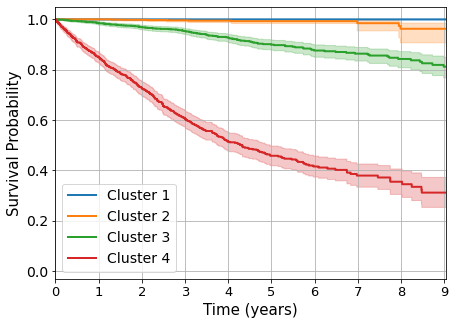

In [1523]:
from lifelines import KaplanMeierFitter

plt.figure(figsize=[7,5])
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

kmf0.fit(km_tte[pred_y == 0], event_observed=km_y[pred_y == 0], label="Cluster 1")
kmf1.fit(km_tte[pred_y == 1], event_observed=km_y[pred_y == 1], label="Cluster 2")
kmf2.fit(km_tte[pred_y == 2], event_observed=km_y[pred_y == 2], label="Cluster 3")
kmf3.fit(km_tte[pred_y == 3], event_observed=km_y[pred_y == 3], label="Cluster 4")

kmf0.plot_survival_function(linewidth=2.)
kmf1.plot_survival_function(linewidth=2.)
kmf2.plot_survival_function(linewidth=2.)
kmf3.plot_survival_function(linewidth=2.)

# plt.title('Survival function of political regimes')
plt.xlim([0, 3300])
plt.xticks((0., 365, 365*2, 365*3, 365*4, 365*5, 365*6, 365*7, 365*8, 365*9), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), fontsize=13)
plt.yticks(fontsize=14)
plt.xlabel('Time (years)', fontsize=15)
plt.ylabel('Survival Probability', fontsize=15)
plt.legend(fontsize=14)
plt.grid()

plt.savefig('./phenotypes_km.png', dpi=200)
plt.show()
plt.close()

In [1380]:
tmp_y     = model.get_lambdas(xs_in, xt_in)
tmp_y_hat = model.get_lambdas_hat(xs_in, xt_in)
tmp_y_bar = model.get_lambdas_bar(xs_in, xt_in)

In [1381]:
for c in np.unique(pred_y):
#     print(np.mean(tmp_y[tmp_m2 == 1][pred_y == c]), np.mean(tmp_y_hat[tmp_m2 == 1][pred_y == c]),  tmp_y_bar[tmp_m2 == 1][pred_y == c][0,0])
    print(c, np.mean(tmp_y[tmp_m2 == 1][pred_y == c]), np.mean(tmp_y_hat[tmp_m2 == 1][pred_y == c]),  sess.run(tf.exp(model.Ey), feed_dict={model.keep_prob:1.})[c, 0])    

0 1.4325738e-07 6.696187e-09 2.309768e-07
3 3.7173508e-05 9.539776e-07 2.2691209e-05
8 3.7577297e-06 1.8325551e-07 2.8262632e-06
9 0.00058172015 1.2660742e-05 0.00021098166


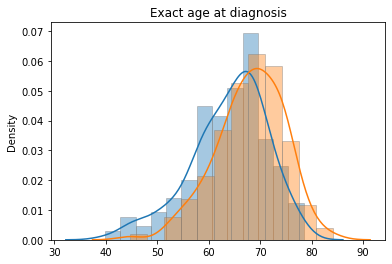

In [1097]:
f_idx = 0

hist_kws=dict(edgecolor="gray", linewidth=1.)


sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xs_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_static[f_idx])
plt.show()
plt.close()

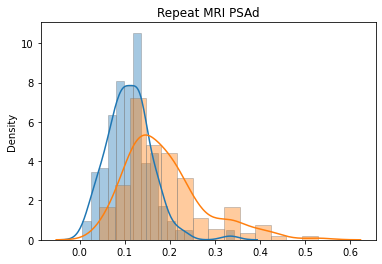

In [1102]:
f_idx = 8

sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_timevarying[f_idx])
plt.show()
plt.close()

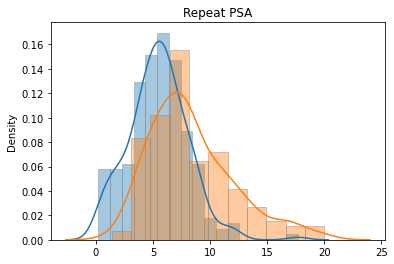

In [1104]:
f_idx = 1

sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 3, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)
sns.distplot(tmp_xt_[np.argmax(tmp_pi, axis=-1)[:, 0] == 9, 0, :][:,f_idx], norm_hist=True, hist_kws=hist_kws)

plt.title(feat_timevarying[f_idx])
plt.show()
plt.close()

# Transition Figures 

In [1382]:
tmp_id = np.zeros_like(tmp_m2)
tmp_id[:, 0] = 1

df_first = pd.DataFrame(tmp_id[tmp_m2 == 1], columns=['first_id'])
df       = pd.DataFrame(pred_y, columns=['phenotype_curr'])
df['phenotype_curr']  = df['phenotype_curr'].apply(lambda x: pheno_mapper[x])

df = pd.concat([df_first, df], axis=1)
df['phenotype_prev'] = np.nan
df.iloc[1:, 2] = np.asarray(df['phenotype_curr'])[:-1]

In [1383]:
tmp_xs_prev = -1 * np.ones_like(tmp_xs)
tmp_xt_prev = -1 * np.ones_like(tmp_xt)

tmp_xs_prev[1:] = tmp_xs[:-1]
tmp_xt_prev[1:] = tmp_xt[:-1]

In [1384]:
matrix/np.sum(matrix, axis=1, keepdims=True)

array([[0.98584906, 0.01415094, 0.        , 0.        ],
       [0.06912442, 0.90585912, 0.02501646, 0.        ],
       [0.        , 0.11955891, 0.85780615, 0.02263494],
       [0.        , 0.        , 0.06972639, 0.93027361]])

In [1385]:
matrix = np.zeros([len(pheno_list), len(pheno_list)])

#current observations
cluster_xs = {}
cluster_xt = {}

#previous observations
cluster_xs_prev = {}
cluster_xt_prev = {}

for prev_c in pheno_list:
    for curr_c in pheno_list:
        tmp = df[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)]
        matrix[prev_c, curr_c] = np.shape(tmp)[0]
        cluster_xs['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xs[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_static)
        cluster_xt['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xt[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_timevarying)
        
        cluster_xs_prev['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xs_prev[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_static)
        cluster_xt_prev['{},{}'.format(prev_c, curr_c)] = pd.DataFrame(tmp_xt_prev[(df['first_id'] != 1) & (df['phenotype_prev'] ==prev_c) & (df['phenotype_curr'] ==curr_c)], columns=feat_timevarying)   

In [1595]:
feat_timevarying

array(['Delta', 'Repeat PSA', 'Repeat Biopsy Core Total',
       'Repeat Biopsy Core Positive', 'Repeat Biopsy Grade Group',
       'Repeat MRI PRECISE Scoring', 'Repeat MRI Stage',
       'Repeat MRI Volume', 'Repeat MRI PSAd'], dtype='<U31')

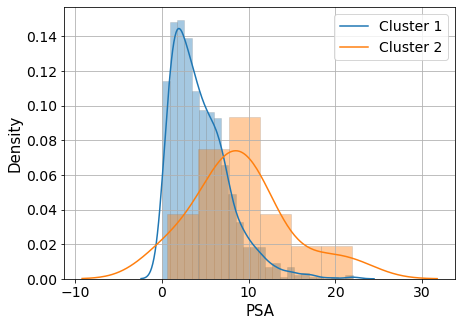

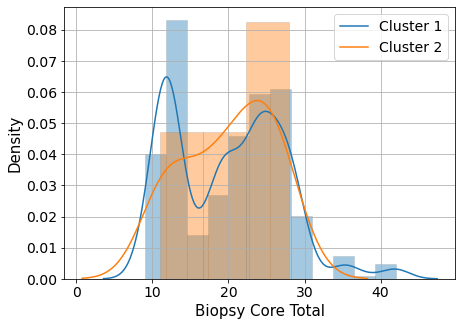

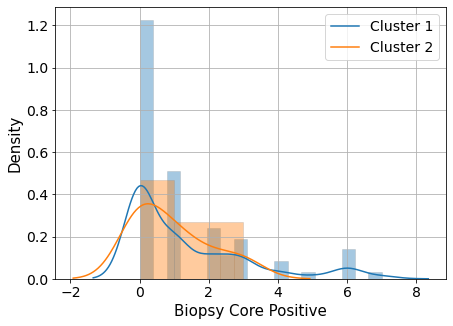

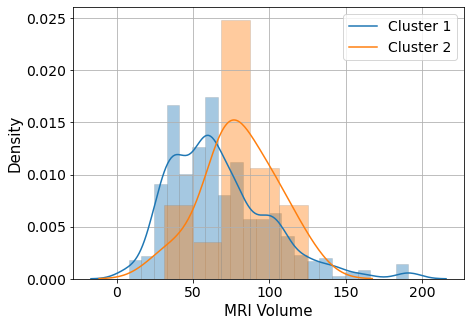

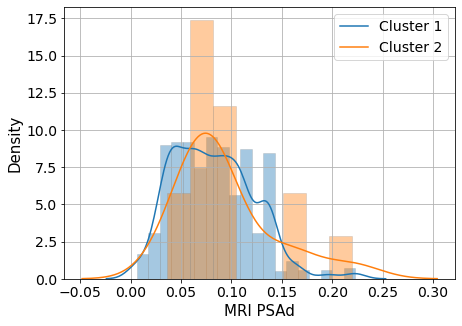

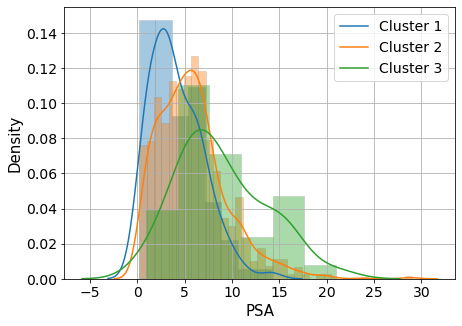

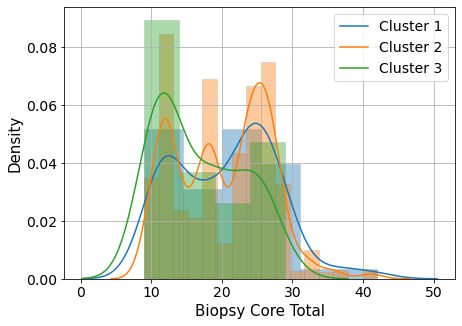

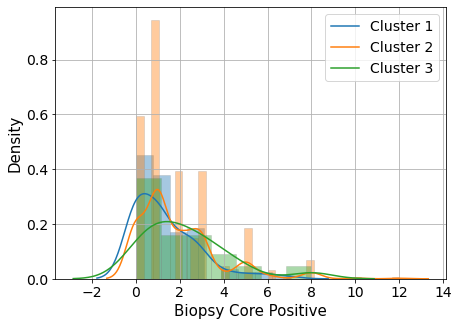

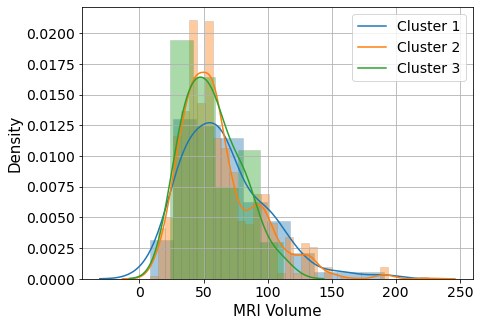

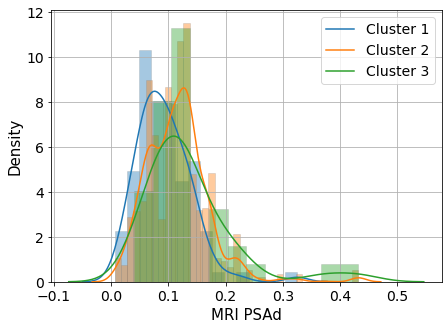

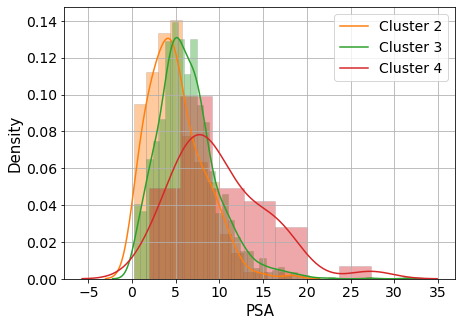

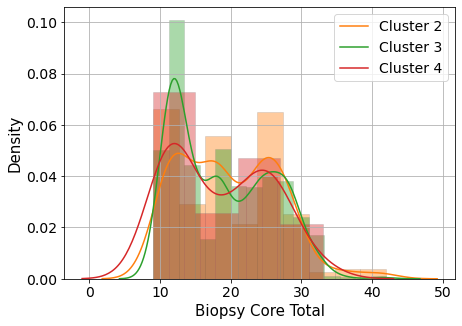

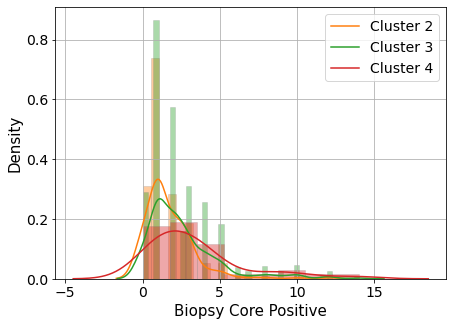

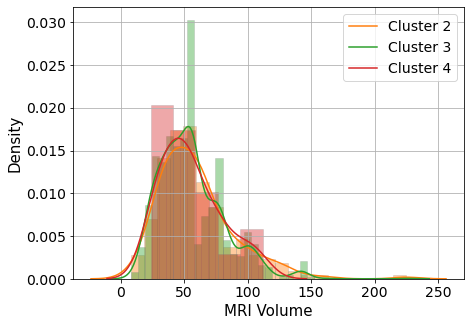

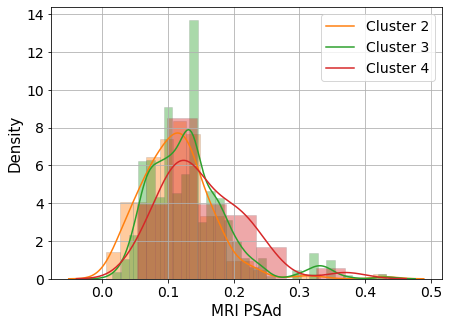

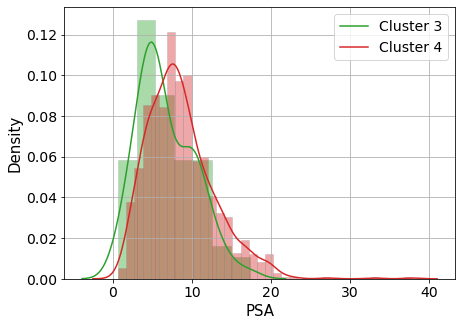

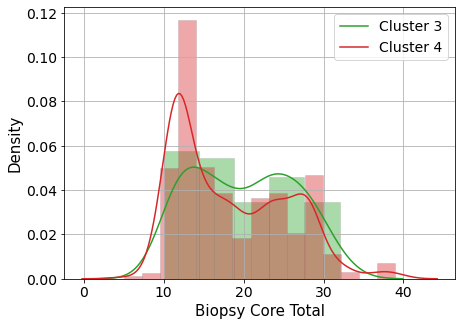

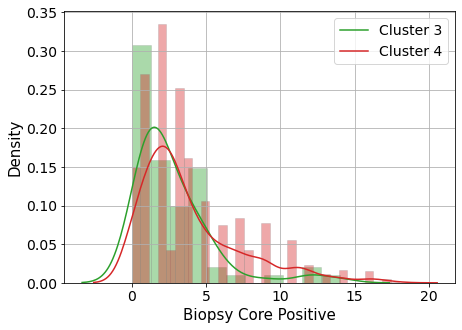

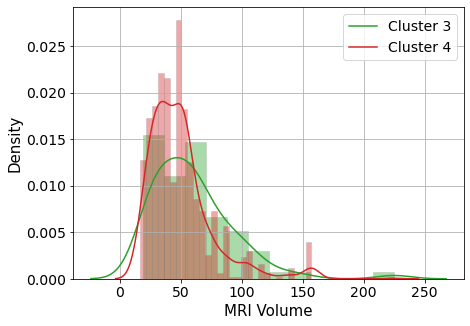

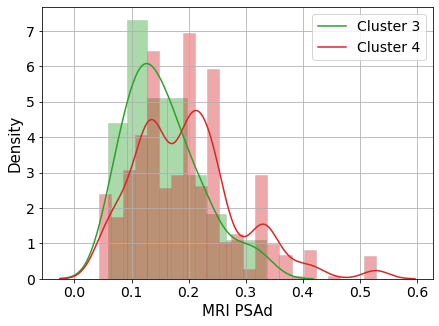

In [1597]:
for pheno_start in [0, 1, 2, 3]:
    for feat in ['Repeat PSA', 'Repeat Biopsy Core Total','Repeat Biopsy Core Positive', 'Repeat MRI Volume', 'Repeat MRI PSAd']:
        plt.figure(figsize=[7,5])
        hist_kws=dict(edgecolor="gray", linewidth=0.5)

        lines  = []
        labels = []

        if len(cluster_xt['{},0'.format(pheno_start)][feat]) != 0:
            line1 = sns.distplot(cluster_xt['{},0'.format(pheno_start)][feat], norm_hist=True, color='C0', hist_kws=hist_kws)
            lines += [line1]
            labels += ['Cluster 1']

        if len(cluster_xt['{},1'.format(pheno_start)][feat]) != 0:
            line2 = sns.distplot(cluster_xt['{},1'.format(pheno_start)][feat], norm_hist=True, color='C1', hist_kws=hist_kws)
            lines += [line2]
            labels += ['Cluster 2']

        if len(cluster_xt['{},2'.format(pheno_start)][feat]) != 0:
            line3 = sns.distplot(cluster_xt['{},2'.format(pheno_start)][feat], norm_hist=True, color='C2', hist_kws=hist_kws)
            lines += [line3]
            labels += ['Cluster 3']

        if len(cluster_xt['{},3'.format(pheno_start)][feat]) != 0:
            line4 = sns.distplot(cluster_xt['{},3'.format(pheno_start)][feat], norm_hist=True, color='C3', hist_kws=hist_kws)
            lines += [line4]
            labels += ['Cluster 4']


        plt.grid()
        # plt.xlim([0,30])

        plt.ylabel('Density', fontsize=15)
        plt.yticks(fontsize=14)
        plt.xlabel('{}'.format(feat.split('Repeat ')[1]), fontsize=15)
        plt.xticks(fontsize=14)

        plt.legend(labels, fontsize=14)
        plt.savefig('./figures/temporal phenotypes/transition_from{}_{}'.format(pheno_start, feat.split('Repeat ')[1]), dpi=200)
        plt.show()
        plt.close()

In [ ]:
feat = 'Repeat Biopsy Grade Group'
for pheno_start in [0,1,2,3]:
    if feat == 'Repeat MRI PRECISE Scoring':
        if pheno_start in [0,3]:
            tmp_bars = np.zeros([2, 5])
        else:
            tmp_bars = np.zeros([3, 5])
    else:
        if pheno_start in [0,3]:
            tmp_bars = np.zeros([2, 3])
        else:
            tmp_bars = np.zeros([3, 3])


    if pheno_start == 0:
        tmp_bars[0, cluster_xt['0,0'][feat].value_counts().index.astype(int)] = cluster_xt['0,0'][feat].value_counts().values
        tmp_bars[1, cluster_xt['0,1'][feat].value_counts().index.astype(int)] = cluster_xt['0,1'][feat].value_counts().values

    elif pheno_start == 1:
        tmp_bars[0, cluster_xt['1,0'][feat].value_counts().index.astype(int)] = cluster_xt['1,0'][feat].value_counts().values
        tmp_bars[1, cluster_xt['1,1'][feat].value_counts().index.astype(int)] = cluster_xt['1,1'][feat].value_counts().values
        tmp_bars[2, cluster_xt['1,2'][feat].value_counts().index.astype(int)] = cluster_xt['1,2'][feat].value_counts().values

    elif pheno_start == 2:
        tmp_bars[0, cluster_xt['2,1'][feat].value_counts().index.astype(int)] = cluster_xt['2,1'][feat].value_counts().values
        tmp_bars[1, cluster_xt['2,2'][feat].value_counts().index.astype(int)] = cluster_xt['2,2'][feat].value_counts().values
        tmp_bars[2, cluster_xt['2,3'][feat].value_counts().index.astype(int)] = cluster_xt['2,3'][feat].value_counts().values

    elif pheno_start == 3:
        tmp_bars[0, cluster_xt['3,2'][feat].value_counts().index.astype(int)] = cluster_xt['3,2'][feat].value_counts().values
        tmp_bars[1, cluster_xt['3,3'][feat].value_counts().index.astype(int)] = cluster_xt['3,3'][feat].value_counts().values

    if feat in ['Repeat Biopsy Grade Group', 'Repeat MRI PRECISE Scoring']:
        tmp_bars = tmp_bars[:, 1:]
    else:
        tmp_bars = tmp_bars[:, :-1] 
    tmp_bars = tmp_bars/np.sum(tmp_bars, axis=1, keepdims=True)


    plt.figure(figsize=[7,5])

    if pheno_start == 0:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C0')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C1')

        pheno_label = ['Cluster 1', 'Cluster 2']

    elif pheno_start == 1:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C0')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C1')
        plt.bar(np.asarray([0, 1])+0.25, tmp_bars[2], width=0.2, color='C2')

        pheno_label = ['Cluster 1', 'Cluster 2', 'Cluster 3']

    elif pheno_start == 2:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C1')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C2')
        plt.bar(np.asarray([0, 1])+0.25, tmp_bars[2], width=0.2, color='C3')

        pheno_label = ['Cluster 2', 'Cluster 3', 'Cluster 4']

    elif pheno_start == 3:
        plt.bar(np.asarray([0, 1])-0.25, tmp_bars[0], width=0.2, color='C2')
        plt.bar(np.asarray([0, 1]), tmp_bars[1], width=0.2, color='C3')

        pheno_label = ['Cluster 3', 'Cluster 4']

    # plt.title('{}'.format(feat))
    plt.grid()
    plt.ylim([0,1])
    plt.ylabel('Frequency', fontsize=15)
    plt.yticks(fontsize=14)

    plt.xlabel('{}'.format('Grade Group'), fontsize=15)
    plt.xticks((0,1), ('1','2'), fontsize=14)

    plt.legend(pheno_label, fontsize=12)

    plt.savefig('./figures/temporal phenotypes/transition_from{}_{}'.format(pheno_start, feat.split('Repeat ')[1]), dpi=200)
    plt.show()
    plt.close()

# PCA + Trajectory figures

In [1270]:
for i in np.where(y_in==0)[0]:
    print(i, np.argmax(tmp_pi, axis=2)[i, :int(np.sum(tmp_m2[i, :]))])


0 [9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8]
3 [3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8]
5 [3 3 3 8 8 8 8 8 8 8 0 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
6 [3 3 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
7 [3 3 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
10 [3 3 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3]
11 [3 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12 [3 8 8 8 8 8 8 8 8 8 8 0 0]
13 [9 9 9 9]
14 [3 3 8 8 0 0 0 0 0 0 0 0 0 0 0 0]
15 [9 9 3 3 3 3 3 3 3 3 3 3]
16 [9 9 3 3 3 8 8 8 0 0 0 0 0 0 0 0 0]
18 [3 3 3 3 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
19 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
20 [3 3 3 3 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0]
21 [3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
23 [3 3 8 8 8 8 8 8 8]
24 [3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 0 0]
26 [3 3 3 3 3 8 8 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8]
27 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

In [1263]:
for i in np.where(y_in)[0]:
    print(i, np.argmax(tmp_pi, axis=2)[i, :int(np.sum(tmp_m2[i, :]))])


1 [9 9]
2 [9 9 9 9]
4 [9 9 9 9 9 9 9 9 9]
9 [9 9 9 9 9 9]
17 [9 9 9 9 9]
22 [9 9 9 9 9 9 9 9 9]
25 [9 9 9]
30 [9 9 9 9 9]
34 [9 9 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
36 [9 9 9 9]
37 [9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
44 [9 9 3 3 9 9 9 9 9 9 9]
63 [9 9 9 9]
89 [9 3]
94 [9 9 9 9 3 3 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
114 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
120 [3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
149 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
158 [3 3 3 3 3 3 3 3 3 3 3 3 9 9 9 9 9]
161 [9 9 9 9 9 9 9 9 9 9 9 9]
176 [9 9 9 9 9 9 9]
183 [9 9 9 9]
186 [9 9 9 9 9 9 9 9 9 9 9]
191 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
199 [9 9 9 9 9 9 9 9 9]
205 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
210 [9 9]
211 [9 9 9 9 9 9]
213 [9 9 9]
221 [9 9 9 9 9 9 9]
225 [9 9 9 9 9 9 9 9 9 9 9 9 9]
227 [9 9 9 3 3 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
231 [9 9 9 9]
233 [9 9 9 9 9 9 9 9]
235 [3 3 3 3 3 3 9]
236 [9 9 9 9 9 9 9 9 9 9 9]
237 [3 3 3 3 3 

In [1674]:
pheno_assignment = np.argmax(tmp_pi, axis=2)
pheno_assignment[pheno_assignment == 0] = 0
pheno_assignment[pheno_assignment == 8] = 1
pheno_assignment[pheno_assignment == 3] = 2
pheno_assignment[pheno_assignment == 9] = 3

In [1687]:
npz = np.load('/home/vdslab/CH/Projects/prostate_temporal/STRATCANS_v1_new2/p1.0/itr2/models_actpc (version 2 - z initialization)/phenotypes.npz')

In [1681]:
np.savez(save_path + '/models_actpc (version 2 - z initialization)/phenotypes.npz',
        pheno_assignment = pheno_assignment,
        mask             = tmp_m2 )

In [1255]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca   = PCA(n_components=2, random_state=seed)
z_pca = pca.fit_transform(tmp_z[tmp_m2==1])

In [1273]:
i = 237
z_pca_event1 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

i = 326
z_pca_event0 = pca.transform(tmp_z[i, :int(np.sum(tmp_m2[i, :])), :])

In [1]:
np.sum(pred_y==0)

NameError: name 'np' is not defined

In [1310]:
from matplotlib.legend import Legend


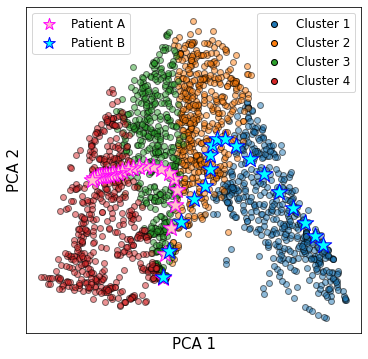

In [1342]:
alpha_ = 0.5

nums = 500
idx0 = random.sample(range(np.sum(pred_y == 0)), nums)
idx1 = random.sample(range(np.sum(pred_y == 1)), nums)
idx2 = random.sample(range(np.sum(pred_y == 2)), nums)
idx3 = random.sample(range(np.sum(pred_y == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_y == 0,0][0], z_pca[pred_y == 0,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_y == 1,0][0], z_pca[pred_y == 1,1][0], alpha=1.0, edgecolors='black', color='C1')
pheno3 = ax.scatter(z_pca[pred_y == 2,0][0], z_pca[pred_y == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
pheno4 = ax.scatter(z_pca[pred_y == 3,0][0], z_pca[pred_y == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_y == 0,0][idx0], z_pca[pred_y == 0,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_y == 1,0][idx1], z_pca[pred_y == 1,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
ax.scatter(z_pca[pred_y == 2,0][idx2], z_pca[pred_y == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
ax.scatter(z_pca[pred_y == 3,0][idx3], z_pca[pred_y == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)
ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

ax.legend([line1, line2], ['Patient A', 'Patient B'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2, pheno3, pheno4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, loc='upper right')
ax.add_artist(leg)

plt.savefig('./phenotypes_pca.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()


In [1638]:
data_xs_org = np.copy(data_xs)
data_xt_org = np.copy(data_xt)

data_xs_org = data_xs_org * (xs_max - xs_min) + xs_min
data_xt_org = data_xt_org * (xt_max - xt_min) + xt_min

data_xt_org = data_xt_org * (np.sum(data_xt, axis=2, keepdims=True) != 0).astype(float)

(tr_data_s_org,te_data_s_org, tr_data_t_org,te_data_t_org) = train_test_split(
    data_xs_org, data_xt_org, test_size=0.2, random_state=seed+out_itr
) 


(tr_data_s_org,va_data_s_org, tr_data_t_org,va_data_t_org) = train_test_split(
    tr_data_s_org, tr_data_t_org, test_size=0.2, random_state=seed+out_itr
)

In [1654]:
from models.cpg_score import predict_cpg

tmp_cpg = np.zeros([np.shape(tr_data_t)[0],np.shape(tr_data_t)[1]])

for i in range(np.shape(tr_data_t)[0]):
    tmp_cpg[i, :seq_length[i]] = predict_cpg(tr_data_t_org[i, :seq_length[i], 1], tr_data_t_org[i, :seq_length[i], 4], tr_data_t_org[i, :seq_length[i], 6], False)

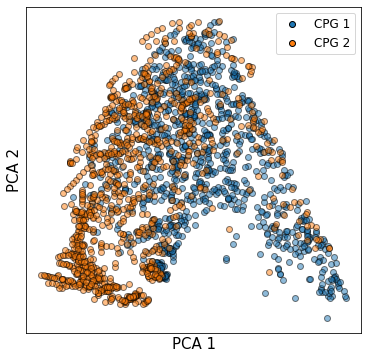

In [1666]:
alpha_ = 0.5

nums = 1000
idx0 = random.sample(range(np.sum(pred_cpg == 1)), nums)
idx1 = random.sample(range(np.sum(pred_cpg == 2)), nums)
# idx2 = random.sample(range(np.sum(pred_y == 2)), nums)
# idx3 = random.sample(range(np.sum(pred_y == 3)), nums)

fig, ax =  plt.subplots(figsize=[6,6])

pheno1 = ax.scatter(z_pca[pred_cpg == 1,0][0], z_pca[pred_cpg == 1,1][0], alpha=1.0, edgecolors='black', color='C0')
pheno2 = ax.scatter(z_pca[pred_cpg == 2,0][0], z_pca[pred_cpg == 2,1][0], alpha=1.0, edgecolors='black', color='C1')
# pheno3 = ax.scatter(z_pca[pred_y == 2,0][0], z_pca[pred_y == 2,1][0], alpha=1.0, edgecolors='black', color='C2')
# pheno4 = ax.scatter(z_pca[pred_y == 3,0][0], z_pca[pred_y == 3,1][0], alpha=1.0, edgecolors='black', color='C3')

ax.scatter(z_pca[pred_cpg == 1,0][idx0], z_pca[pred_cpg == 1,1][idx0], alpha=alpha_, edgecolors='black', color='C0')
ax.scatter(z_pca[pred_cpg == 2,0][idx1], z_pca[pred_cpg == 2,1][idx1], alpha=alpha_, edgecolors='black', color='C1')
# ax.scatter(z_pca[pred_y == 2,0][idx2], z_pca[pred_y == 2,1][idx2], alpha=alpha_, edgecolors='black', color='C2')
# ax.scatter(z_pca[pred_y == 3,0][idx3], z_pca[pred_y == 3,1][idx3], alpha=alpha_, edgecolors='black', color='C3')

# line1 = ax.scatter(z_pca_event1[0, 0], z_pca_event1[0, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 150)
# line2 = ax.scatter(z_pca_event0[0, 0], z_pca_event0[0, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 150)
# ax.scatter(z_pca_event1[:, 0], z_pca_event1[:, 1], alpha=1., edgecolors='magenta', color='pink', marker='*', s= 300)
# ax.scatter(z_pca_event0[:, 0], z_pca_event0[:, 1], alpha=1., edgecolors='blue', color='cyan', marker='*', s= 300)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCA 1', fontsize=15)
ax.set_ylabel('PCA 2', fontsize=15)

# ax.legend([line1, line2], ['Patient A', 'Patient B'], fontsize=12, loc='upper left')
leg = Legend(ax, [pheno1, pheno2], ['CPG 1', 'CPG 2'], fontsize=12, loc='upper right')
ax.add_artist(leg)

plt.savefig('./cpg_pca.png', dpi=200)
plt.show()
plt.close()

# plt.scatter(z_pca_last[new_pred_y_last == 1,0], z_pca_last[new_pred_y_last == 1,1], alpha=alpha_, edgecolors='black', color='C0')
# plt.scatter(z_pca_last[new_pred_y_last == 2,0], z_pca_last[new_pred_y_last == 2,1], alpha=alpha_, edgecolors='black', color='C1')
# plt.scatter(z_pca_last[new_pred_y_last == 3,0], z_pca_last[new_pred_y_last == 3,1], alpha=alpha_, edgecolors='black', color='C2')
# plt.show()
# plt.close()
